# ML Recommender System: Collaborative Filtering

Useful libraries to import:

In [1]:
from collaborative import *
from pre_post_process import *
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

## 1. Data Loading

Load the data. We also need the sample ids as those are the ratings that we want to predict.

In [2]:
ids, ratings_matrix = load_data("data_train.csv")
sample_ids, sample_matrix = load_data("sample_submission.csv")

number of items: 1000, number of users: 10000
number of items: 1000, number of users: 10000


Split Data

In [3]:
_, train_ratings, test_ratings = split_data(ratings_matrix, p_test = 0.1)

the shape of original ratings. (# of row, # of col): (1000, 10000)
the shape of valid ratings. (# of row, # of col): (1000, 10000)
Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1068598
Total number of nonzero elements in test data:108354


In [4]:
# Get the ratings we want to predict for submission
ratings_to_predict_submiss = movie_user_predictions(sample_ids)

# Get the test ratings and ids we want to test our model on
nz_row, nz_col = test_ratings.nonzero()
nz_test = list(zip(nz_row, nz_col))
test_ids = np.zeros((len(nz_test), 2), dtype=np.int)
ratings_test = []
for i, elem in enumerate(nz_test):
    test_ids[i] = [elem[1] + 1, elem[0] + 1]
    ratings_test.append(test_ratings[elem[0], elem[1]]) 
ratings_to_predict_test = movie_user_predictions(test_ids)

In [5]:
# Test that above computations are working as expected
print(ratings_to_predict_test[0][:5])
print(ratings_test[:6])
print(test_ids)

[317, 389, 565, 594, 776]
[1.0, 4.0, 3.0, 2.0, 5.0, 4.0]
[[ 318    1]
 [ 390    1]
 [ 566    1]
 ..., 
 [9771 1000]
 [9904 1000]
 [9976 1000]]


## 2. Statistics on the data

In [6]:
# Use np.matrix instead of sp.sparse matrix to do the statistics
statistics_ratings = np.zeros((1000,10000), dtype = np.float64)
ratings_matrix.todense(out = statistics_ratings)

nb_users, nb_movies = 10000, 1000
mean = np.mean(statistics_ratings[statistics_ratings != 0])
print("Mean of the ratings: {}".format(mean))
sparsity = 100 * (1 - (len(statistics_ratings[statistics_ratings != 0]) / (nb_users * nb_movies)))
print("Sparsity of the matrix: {}%".format(sparsity))
ratings_per_user = np.count_nonzero(statistics_ratings, axis = 1)
ratings_per_movie = np.count_nonzero(statistics_ratings, axis = 0)
print("The median of ratings amount per user is {}".format(np.median(ratings_per_user)))
print("The median of ratings amount per movie is {}".format(np.median(ratings_per_movie)))
print("Minimum ratings: {}, Maximum ratings: {}".format(min(ratings_per_user), max(ratings_per_user)))

Mean of the ratings: 3.8572805008190647
Sparsity of the matrix: 88.23048%
The median of ratings amount per user is 883.5
The median of ratings amount per movie is 104.0
Minimum ratings: 8, Maximum ratings: 4590


Distribution of the value of ratings:

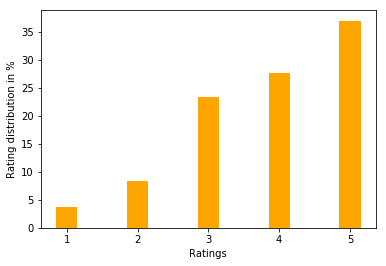

[ 43508  99180 274327 324700 435237]
[1 2 3 4 5 6]


In [7]:
distrib_ratings, bins_ratings = np.histogram(statistics_ratings[statistics_ratings != 0], bins = [1, 2, 3, 4, 5, 6])
percentages_ratings = 100 * distrib_ratings / np.sum(distrib_ratings)

plt.bar(bins_ratings[:-1], percentages_ratings, width = 0.3, color = 'orange')
plt.xlabel("Ratings")
plt.ylabel("Rating distribution in %")
plt.show()

print(distrib_ratings)
print(bins_ratings)

Distribution of number of ratings:

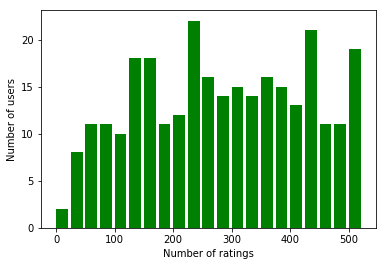

In [8]:
### Compute number of movies seen by each user
movies_rated = np.count_nonzero(statistics_ratings, axis = 1)

distrib_movies, bins_movies = np.histogram(movies_rated, bins = range(0,550,25))
plt.bar(bins_movies[:-1], distrib_movies, width = 20, color = 'green', align = 'edge')
plt.xlabel("Number of ratings")
plt.ylabel("Number of users")
plt.show()

## 3. Algorithms

The recommender system designed through this project uses the User-User Collaborative Filtering method. Collaborative filtering (CF) is a popular recommendation algorithm that bases the predictions and recommendations on the past ratings of users in the system. Thus, User-user CF consists of finding other users whose past rating behavior is similar to the one of the current user and uses their ratings on other items to predict what the current user will like.

To compute the predictions for each user in the algorithm, we need a similarity function $s(u, v)$ computing the similarity between two users: u and v. The similarity function is used to compute a neighborhood $\mathbf{K} \subseteq U$ for each user u that consists of the K users that are most similar to u. Finally, the predicted rating for user u and movie i will be computed using the set of neighbors $\mathbf{K}$ , as follows:
    
$$p_{u, i} = \frac{\sum_{v \in \mathbf{K}} s(u, v) . r_{v,i}}{\sum_{v \in \mathbf{K}} |s(u, v)|}$$
    
where ${r}_{v,i}$ is the rating user v gave to movie i

### 3.1 Similarity functions

We need a similarity function to compute all similarities between users or movies, we will try the following functions:
    - cosine similarity
    - pearson correlation

In [9]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import correlation

def getCosineMatrix(ratings, mode = 'cosine'):
    nb_movies, nb_users = ratings.shape
    ### similarity = 1 - distance
    cosine_matrix = np.ones((nb_users, nb_users)) - sk.metrics.pairwise_distances(ratings.T.todense(), metric=mode)
    ### Set to 0 the similarity from user to itself
    cosine_matrix -= np.identity(nb_users)
    return cosine_matrix

In [10]:
cosMatrix = getCosineMatrix(train_ratings)
pearsonMatrix = getCosineMatrix(train_ratings, mode = 'correlation')

### 3.3 Predict the ratings

In [10]:
def rmse(preds, ratings):
    """Compute rmse given 2 lists: predictions and real ratings"""
    loss = np.sqrt(np.sum((np.array(preds) - np.array(ratings))**2) / len(preds))
    return loss

Compute predictions with tweak of parameters: similarity matrix and number of best neighbors to see which parameters give lowest rmse on testing set

In [185]:
# Convert sparse matrix (lil_matrix) to a numpy matrix in order to do some possible computations
train_dense = np.zeros((1000,10000), dtype = np.float64)
train_ratings.todense(out = train_dense)

neighbors = [10, 30, 50, 75, 100, 150, 200, 300, 500, 750, 1000]
print("Cosine similarities:")
for K in neighbors:
    predictions_matrix = compute_matrix_predictions(train_dense.T, ratings_to_predict_test, cosMatrix, K)
    # Transform matrix to list
    preds = [p for movie_preds in predictions_matrix for p in movie_preds]
    loss = rmse(preds, ratings_test)
    print("K = {}, rmse = {}".format(K, loss))
    
print("Pearson correlation:")
for K in neighbors:
    predictions_matrix = compute_matrix_predictions(train_dense.T, ratings_to_predict_test, pearsonMatrix, K)
    # Transform matrix to list
    preds = [p for movie_preds in predictions_matrix for p in movie_preds]
    loss = rmse(preds, ratings_test)
    print("K = {}, rmse = {}".format(K, loss))

Cosine similarities:
K = 10, rmse = 1.0588374949858328
K = 30, rmse = 1.0301089847174265
K = 50, rmse = 1.0256212659879005
K = 75, rmse = 1.023209280063811
K = 100, rmse = 1.0227258908527856
K = 150, rmse = 1.0223733877122745
K = 200, rmse = 1.0223220929980306
K = 300, rmse = 1.0228998663617654
K = 500, rmse = 1.0240699601525114
K = 750, rmse = 1.0251494240940393
K = 1000, rmse = 1.025817712018517
Pearson correlation:
K = 10, rmse = 1.0618821010859054
K = 30, rmse = 1.0303208171281697
K = 50, rmse = 1.0242857391675433
K = 75, rmse = 1.021927814574723
K = 100, rmse = 1.020327115669013
K = 150, rmse = 1.019752110583573
K = 200, rmse = 1.0197182775513638
K = 300, rmse = 1.0200307262005475
K = 500, rmse = 1.0212216563651997
K = 750, rmse = 1.0224759195269695
K = 1000, rmse = 1.023454915136376


Best results using Pearson correlations with K = 200 best neighbors for each user

In [11]:
pearsonMatrix = getCosineMatrix(ratings_matrix, mode = 'correlation')

In [12]:
# Convert sparse matrix (lil_matrix) to a numpy matrix in order to do some possible computations
ratings_dense = np.zeros((1000,10000), dtype = np.float64)
ratings_matrix.todense(out = ratings_dense)
K = 200

# Compute predictions for submissions
predictions_matrix = compute_matrix_predictions(ratings_dense.T, ratings_to_predict_submiss, pearsonMatrix, K)
# Transform matrix to list
preds = [p for movie_preds in predictions_matrix for p in movie_preds]

## 4. Submission

In [20]:
### Create csv submission
create_csv_submission(sample_ids, preds, "user-userCF.csv")